# EXTENSION: Additional Evaluations

Our approach differs from token-level entropy by calculating "semantic entropy" over a broader context. However, TriviaQA's short-answer format may not fully showcase this difference. The gap between token-level and semantic-level entropy values might be subtle in such cases. To better evaluate our method, we'll test it on two datasets that require longer, more detailed responses.

## Analysis I: GSM8K Dataset

The GSM8K dataset aligns well with our goals, as it requires generating long-form solutions. Additionally, the evaluation can be conducted via string matching after the #### delimiter in the output, simplifying the evalaution process.

### Tasks:

1) Create train/validation/test splits. \\
2) Choose few shot examples, exclude them from the splits \\

## Set Up:

In [ ]:
!pip install transformers datasets torch tqdm scikit-learn matplotlib accelerate

In [ ]:
#!pip install --upgrade pyarrow datasets

In [ ]:
#!pip install pyarrow==14.0.1
#!pip install --upgrade datasets

In [2]:
import torch
import accelerate
from torch.nn import functional as F
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification
from datasets import load_from_disk, load_dataset
import random
import math
import os
from google.colab import drive
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd

In [3]:
import os
token = os.environ['HF_TOKEN']

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Define the base path in your Google Drive
base_path = "/content/drive/MyDrive/hallucination-detector/"

# Create the directory if it doesn't exist
import os
os.makedirs(base_path, exist_ok=True)

## Data Preprocessing

In [ ]:
# Load the dataset
gsm8k_dataset = load_dataset("openai/gsm8k", "main")
gsm8k_train = gsm8k_dataset['train']
gsm8k_test = gsm8k_dataset['test']

# Shuffle the dataset
gsm8k_train = gsm8k_train.shuffle(seed=42)
gsm8k_test = gsm8k_test.shuffle(seed=42)

In [ ]:
train_ds = gsm8k_train.select(range(5000))
valid_ds = gsm8k_train.select(range(5000,7000))
test_ds = gsm8k_test

print(f"training split size: {len(train_ds)}")
print(f"validation split size: {len(valid_ds)}")
print(f"test split size: {len(test_ds)}")

training split size: 5000
validation split size: 2000
test split size: 1319


## Model Testing

In [ ]:
print("Loading Gemma 2B model and tokenizer...")
gemma_tokenizer = AutoTokenizer.from_pretrained("google/gemma-2b-it", token=token)
gemma_model = AutoModelForCausalLM.from_pretrained(
    "google/gemma-2b-it",
    device_map="auto",
    torch_dtype=torch.bfloat16,
    output_hidden_states=True,
    token=token
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

For fair evaluation, few-shot examples are typically chosen randomly. However, in this case, we aim to maximize the model's accuracy to ensure a sufficient number of positively labeled sequences. This allows the model to effectively learn the contrast between hallucinated and non-hallucinated content. Due to the complexity of the task and the size of the Gemma-2B model, the model is likely to hallucinate in most instances. The official Gemma technical report indicates an accuracy of only 14% for this task. Therefore, to provide the model with the best possible assistance, we carefully hand-selected the few-shot examples.

## Best Guess and 10 Alternative Generations

In [ ]:
few_shot_gsm8k = f"""
Question: {gsm8k_train[7001]['question']}
Answer: {gsm8k_train[7001]['answer']}\n
Question: {gsm8k_train[7006]['question']}
Answer: {gsm8k_train[7006]['answer']}\n
Question: {gsm8k_train[7008]['question']}
Answer: {gsm8k_train[7008]['answer']}\n
Question: {gsm8k_train[7010]['question']}
Answer: {gsm8k_train[7010]['answer']}\n
Question: {gsm8k_train[7012]['question']}
Answer: {gsm8k_train[7012]['answer']}\n
"""

def format_question_with_examples(question):
    return f"{few_shot_gsm8k}Question: {question}\nAnswer:"

In [ ]:
import pandas as pd
import torch
import os
from tqdm import tqdm
import ast

def generate_predictions_batch(questions, num_alternatives=10, temperature=0.8, top_p=0.9):
    formatted_questions = [format_question_with_examples(q) for q in questions]
    inputs = gemma_tokenizer(formatted_questions, return_tensors="pt", padding=True, truncation=True).to(device)
    max_length = inputs.input_ids.size(1) + 200

    with torch.no_grad():
        outputs = gemma_model.generate(**inputs, max_length=max_length,
                                       num_return_sequences=num_alternatives,
                                       do_sample=True,
                                       top_p=top_p,
                                       temperature=temperature)

    # Reshape outputs to group by question
    outputs = outputs.reshape(len(questions), num_alternatives, -1)

    all_alternatives = []
    for i, formatted_q in enumerate(formatted_questions):
        responses = gemma_tokenizer.batch_decode(outputs[i], skip_special_tokens=True)
        predictions = [response[len(formatted_q):].strip() for response in responses]
        all_alternatives.append(predictions)

    return all_alternatives

def process_dataset(dataset, name, batch_size=1, checkpoint_interval=10, num_alternatives=10, temperature=0.8, top_p=0.9):
    output_file = f"/content/drive/MyDrive/hallucination-detector/gsm8k_{name}_gemma_alternatives.csv"

    # Check for existing file and determine starting point
    if os.path.exists(output_file):
        existing_df = pd.read_csv(output_file)
        start_index = len(existing_df)
        results = existing_df.to_dict('records')
    else:
        start_index = 0
        results = []

    for i in tqdm(range(start_index, len(dataset), batch_size), desc=f"Processing {name}"):
        batch = dataset[i:i+batch_size]

        questions = batch['question']
        answers = batch['answer']

        alternatives = generate_predictions_batch(questions, num_alternatives=num_alternatives,
                                                  temperature=temperature, top_p=top_p)

        for q, a, alts in zip(questions, answers, alternatives):
            results.append({
                'question': q,
                'answer': a,
                'alternatives': str(alts)  # Convert list to string for CSV storage
            })

        # Write to CSV after processing every 5 questions
        if (i + batch_size) % (checkpoint_interval * batch_size) == 0 or (i + batch_size) >= len(dataset):
            df = pd.DataFrame(results)
            df.to_csv(output_file, index=False)
            print(f"Checkpoint saved. Processed {len(results)} questions.")

    print(f"{name.capitalize()} dataset processing complete. CSV file saved to {output_file}")

In [ ]:
# Process each dataset
datasets = [('train', train_ds), ('valid', valid_ds)]

for dataset_name, dataset in datasets:
    process_dataset(dataset, dataset_name, num_alternatives=10, temperature=0.8, top_p=0.9)

In [ ]:
# After processing, when you want to load and use the data:
def load_processed_data(file_path):
    df = pd.read_csv(file_path)
    df['alternatives'] = df['alternatives'].apply(ast.literal_eval)
    return df

# Example usage:
# train_data = load_processed_data("/content/drive/MyDrive/hallucination-detector/gsm8k_train_gemma_alternatives.csv")
# valid_data = load_processed_data("/content/drive/MyDrive/hallucination-detector/gsm8k_valid_gemma_alternatives.csv")

Now, let's generate the temperature=0 best guess for each question in all train/valid/test splits

# Best Guess Answer and Associated Hidden Vector

In [ ]:
import pandas as pd
import torch
import os
from tqdm import tqdm
import numpy as np

def generate_greedy_answer_and_embedding(questions, num_additional_tokens=200):
    formatted_questions = [format_question_with_examples(q) for q in questions]
    inputs = gemma_tokenizer(formatted_questions, return_tensors="pt", padding=True, truncation=True).to(device)
    question_lengths = inputs.attention_mask.sum(dim=1)
    max_length = inputs.input_ids.size(1) + num_additional_tokens

    with torch.no_grad():
        generation_outputs = gemma_model.generate(
            **inputs,
            max_length=max_length,
            num_return_sequences=1,
            temperature=0,
            do_sample=False,
            return_dict_in_generate=True,
            output_hidden_states=True
        )

        generated_sequences = generation_outputs.sequences
        full_responses = gemma_tokenizer.batch_decode(generated_sequences, skip_special_tokens=True)
        answers = [full_response[len(formatted_q):].strip() for full_response, formatted_q in zip(full_responses, formatted_questions)]

        # Extract the last token's embedding for each question
        last_token_embeddings = [generation_outputs.hidden_states[0][-1][i][question_length-1].float().cpu().numpy()
                                 for i, question_length in enumerate(question_lengths)]

    # Clear intermediate variables
    del inputs, generation_outputs, generated_sequences
    torch.cuda.empty_cache()

    return answers, last_token_embeddings

def process_dataset_greedy(dataset, name, batch_size=8):
    output_file = f"/content/drive/MyDrive/hallucination-detector/gsm8k_{name}_gemma_greedy_labels.csv"

    # Check for existing file and determine starting point
    if os.path.exists(output_file):
        existing_df = pd.read_csv(output_file)
        start_index = len(existing_df)
        results = existing_df.to_dict('records')
    else:
        start_index = 0
        results = []

    for i in tqdm(range(start_index, len(dataset), batch_size), desc=f"Processing {name}"):
        batch = dataset[i:i+batch_size]
        questions = batch['question']
        answers = batch['answer']

        generated_answers, embeddings = generate_greedy_answer_and_embedding(questions)

        for q, a, gen_a, emb in zip(questions, answers, generated_answers, embeddings):
            results.append({
                'question': q,
                'answer': a,
                'generated_answer': gen_a,
                'embedding': emb.tolist()  # Convert numpy array to list for CSV storage
            })

        # Write to CSV after processing every batch
        df = pd.DataFrame(results)
        df.to_csv(output_file, index=False)
        print(f"Checkpoint saved. Processed {len(results)} questions.")

    print(f"{name.capitalize()} dataset processing complete. CSV file saved to {output_file}")

# Usage
process_dataset_greedy(train_ds, "train")
process_dataset_greedy(valid_ds, "valid")
process_dataset_greedy(test_ds, "test")

## Helper Functions

In [13]:
import ast
import pandas as pd
import re
from collections import Counter
import math

def extract_number(string):
    pattern = r'-?\d+/\d+|-?\d*\.?\d+'
    numbers = re.findall(pattern, string)

    if numbers:
        last_number = numbers[-1]

        if '/' in last_number:
            numerator, denominator = map(int, last_number.split('/'))
            result = numerator / denominator
        else:
            result = float(last_number)

        return f"{result:.2f}"
    else:
        return "None"

def calculate_entropy(frequencies):
    total = sum(frequencies)
    probabilities = [f / total for f in frequencies]
    entropy = -sum(p * math.log2(p) for p in probabilities if p > 0)
    return f"{entropy:.2f}"

def process_dataframe(df):
    # Apply extract_number to 'answer' and 'generated_answer' columns
    df['answer_y'] = df['answer'].apply(extract_number)
    df['generated_answer_y'] = df['generated_answer'].apply(extract_number)

    def process_alternatives(alt_string):
        alt_list = ast.literal_eval(alt_string)
        return [extract_number(alt) for alt in alt_list]

    df['alternatives_y'] = df['alternatives'].apply(process_alternatives)

    def get_frequencies(alt_y):
        counter = Counter(alt_y)
        none_count = counter.pop("None", 0)
        frequencies = list(counter.values())
        if none_count > 0:
            frequencies.append(none_count)
        return [str(f) for f in frequencies]

    df['frequencies'] = df['alternatives_y'].apply(get_frequencies)

    df['entropy'] = df['frequencies'].apply(lambda x: calculate_entropy([int(f) for f in x]))

    return df

def process_dataframe_without_alternatives(df):
    # Apply extract_number to 'answer' and 'generated_answer' columns
    df['answer_y'] = df['answer'].apply(extract_number)
    df['generated_answer_y'] = df['generated_answer'].apply(extract_number)

    return df

# You can now use either function depending on whether you have the 'alternatives' column or not

# For dataframes with 'alternatives' column:
# merged_df_train = process_dataframe(merged_df_train)

# For dataframes without 'alternatives' column:
# merged_df_train = process_dataframe_without_alternatives(merged_df_train)

## Analyzing the Resulting Outputs

In [7]:
best_guess_df_train = pd.read_csv("/content/drive/MyDrive/hallucination-detector/gsm8k_train_gemma_greedy_labels.csv")
best_guess_df_valid = pd.read_csv("/content/drive/MyDrive/hallucination-detector/gsm8k_valid_gemma_greedy_labels.csv")
best_guess_df_test = pd.read_csv("/content/drive/MyDrive/hallucination-detector/gsm8k_test_gemma_greedy_labels.csv")

alternatives_df_train = pd.read_csv("/content/drive/MyDrive/hallucination-detector/gsm8k_train_gemma_alternatives.csv")
alternatives_df_valid = pd.read_csv("/content/drive/MyDrive/hallucination-detector/gsm8k_valid_gemma_alternatives.csv")

In [8]:
common_columns = ['question', 'answer']

# Identify unique columns in each dataframe
best_guess_unique = [col for col in best_guess_df_train.columns if col not in common_columns]
alternatives_unique = [col for col in alternatives_df_train.columns if col not in common_columns]

# Merge the dataframes
merged_df_train = best_guess_df_train[common_columns + best_guess_unique].merge(
    alternatives_df_train[alternatives_unique],
    left_index=True,
    right_index=True
)

In [9]:
common_columns = ['question', 'answer']

# Identify unique columns in each dataframe
best_guess_unique = [col for col in best_guess_df_valid.columns if col not in common_columns]
alternatives_unique = [col for col in alternatives_df_valid.columns if col not in common_columns]

# Merge the dataframes
merged_df_valid = best_guess_df_valid[common_columns + best_guess_unique].merge(
    alternatives_df_valid[alternatives_unique],
    left_index=True,
    right_index=True
)

In [10]:
merged_df_test = best_guess_df_test

#### Extracting the numbers

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, f1_score
import os
import joblib

In [14]:
# Apply the function to your dataframe
df_train = process_dataframe(merged_df_train)
df_valid = process_dataframe(merged_df_valid)
df_test = process_dataframe_without_alternatives(merged_df_test)

In [ ]:
# Combine train and validation sets
combined_df = pd.concat([df_train, df_valid])

# Convert 'entropy' to numeric, replacing any non-convertible values with NaN
combined_df['entropy'] = pd.to_numeric(combined_df['entropy'], errors='coerce')

# Convert 'embedding' from string to list
combined_df['embedding'] = combined_df['embedding'].apply(ast.literal_eval)

# Remove rows with NaN values in the 'entropy' column
combined_df = combined_df.dropna(subset=['entropy'])

# Create 'is_correct' column for combined_df and df_test
combined_df['is_correct'] = (combined_df['answer_y'] == combined_df['generated_answer_y']).astype(int)
df_test['is_correct'] = (df_test['answer_y'] == df_test['generated_answer_y']).astype(int)

print(combined_df.columns)
print(df_test.columns)
print(combined_df['is_correct'].value_counts(normalize=True))
print(f"Number of samples in combined set: {len(combined_df)}")
print(f"Number of samples in test set: {len(df_test)}")

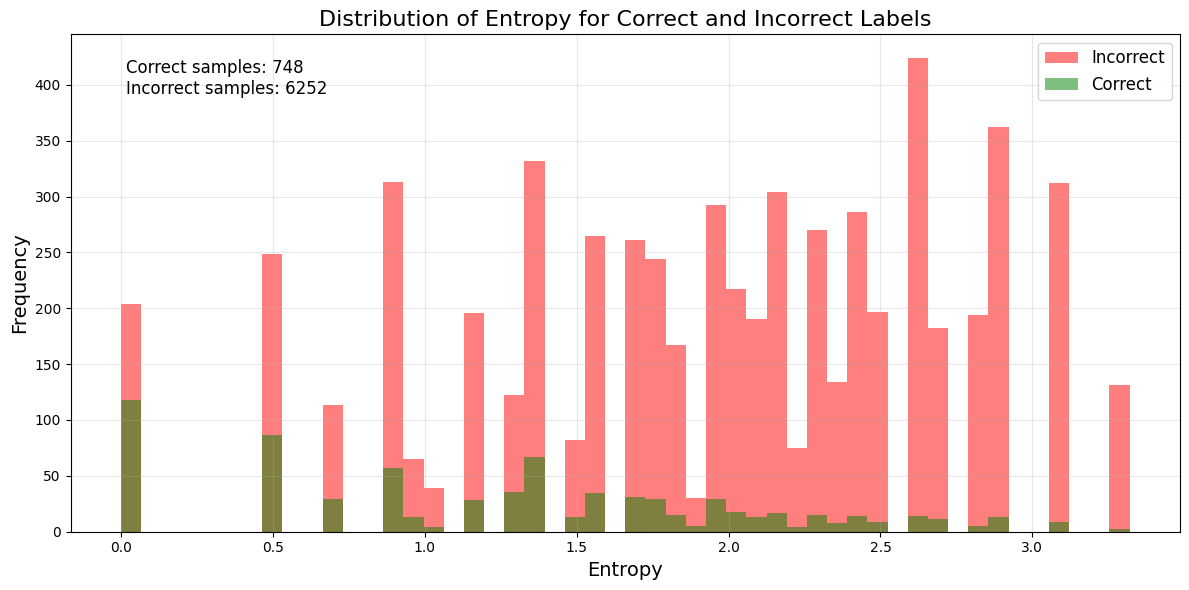

Correct labels - Mean: 1.2674, Std: 0.8477
Incorrect labels - Mean: 1.9558, Std: 0.8009


In [21]:
# Separate the data for correct and incorrect labels
correct_entropy = combined_df[combined_df['is_correct'] == 1]['entropy']
incorrect_entropy = combined_df[combined_df['is_correct'] == 0]['entropy']

# Define the number of bins and range
bins = 50
range_min = min(combined_df['entropy'].min(), 0)  # In case there are negative values
range_max = combined_df['entropy'].max()

# Create the plot
plt.figure(figsize=(12, 6))

# Plot histogram for incorrect labels (red)
plt.hist(incorrect_entropy, bins=bins, range=(range_min, range_max), color='red', alpha=0.5, label='Incorrect')

# Plot histogram for correct labels (green)
plt.hist(correct_entropy, bins=bins, range=(range_min, range_max), color='green', alpha=0.5, label='Correct')

# Customize the plot
plt.title('Distribution of Entropy for Correct and Incorrect Labels', fontsize=16)
plt.xlabel('Entropy', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Add text with data statistics
plt.text(0.05, 0.95, f"Correct samples: {len(correct_entropy)}\nIncorrect samples: {len(incorrect_entropy)}",
         transform=plt.gca().transAxes, verticalalignment='top', fontsize=12)

plt.tight_layout()
plt.show()

# Print some statistics
print(f"Correct labels - Mean: {correct_entropy.mean():.4f}, Std: {correct_entropy.std():.4f}")
print(f"Incorrect labels - Mean: {incorrect_entropy.mean():.4f}, Std: {incorrect_entropy.std():.4f}")

Creating the ROC graph, when semantic entropy is used as the predictor of hallucination

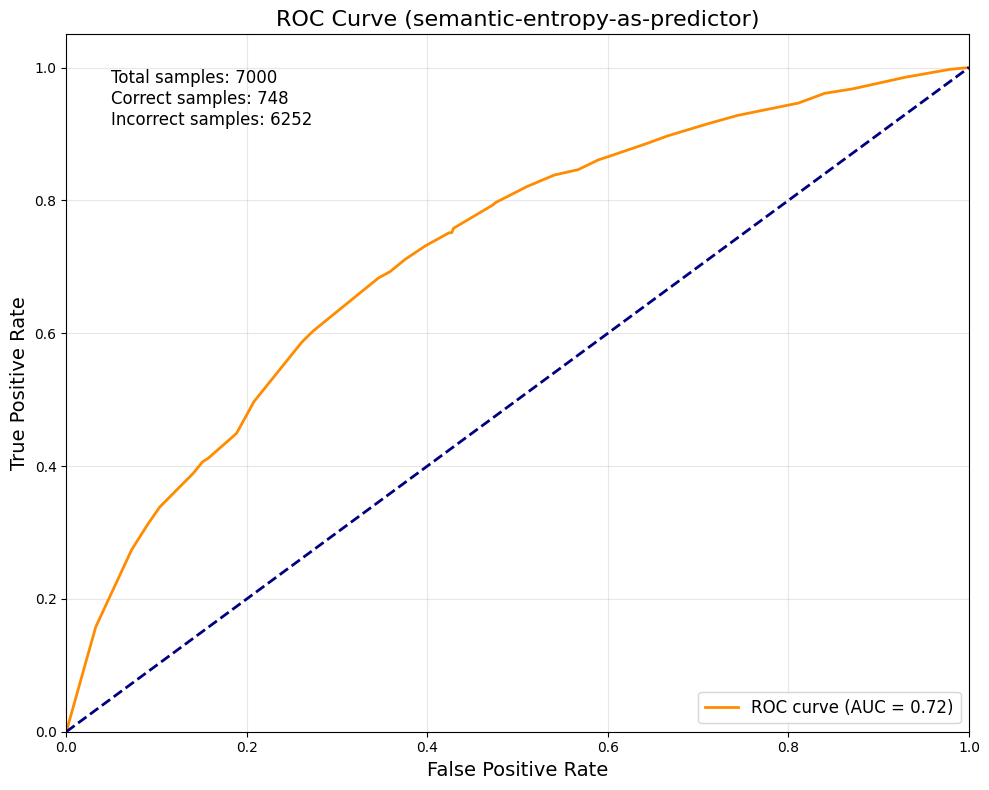

AUC-ROC Score: 0.7230
Best Threshold: 1.6900


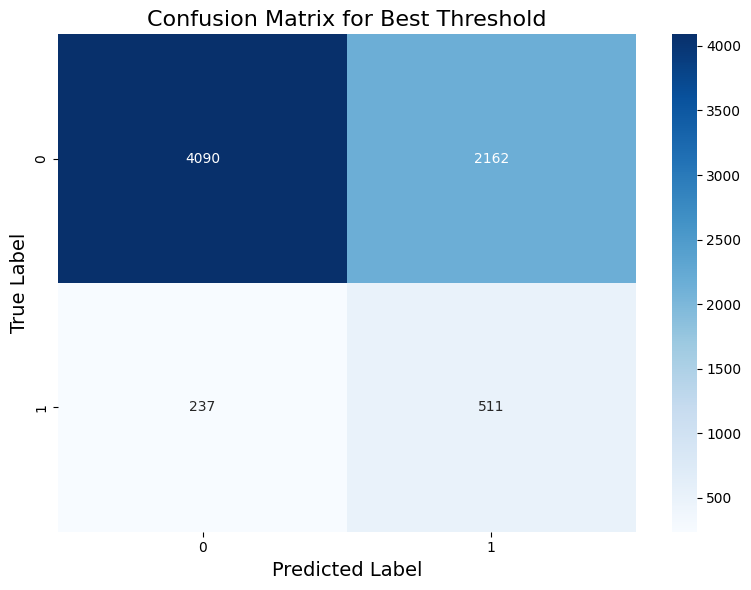


Classification Report:
              precision    recall  f1-score   support

   Incorrect       0.95      0.65      0.77      6252
     Correct       0.19      0.68      0.30       748

    accuracy                           0.66      7000
   macro avg       0.57      0.67      0.54      7000
weighted avg       0.86      0.66      0.72      7000



In [22]:
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming combined_df is your DataFrame with 'entropy' and 'is_correct' columns

# Prepare the data
y_true = combined_df['is_correct']
y_scores = -combined_df['entropy']  # Negative because lower entropy means higher confidence

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Find the best threshold using Youden's J statistic
j_scores = tpr - fpr
best_idx = np.argmax(j_scores)
best_threshold = thresholds[best_idx]

# Create predictions using the best threshold
y_pred = (y_scores >= best_threshold).astype(int)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create the ROC curve plot
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve (semantic-entropy-as-predictor)', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)

# Add text with data statistics
plt.text(0.05, 0.95, f"Total samples: {len(y_true)}\nCorrect samples: {sum(y_true)}\nIncorrect samples: {len(y_true) - sum(y_true)}",
         transform=plt.gca().transAxes, verticalalignment='top', fontsize=12)

plt.tight_layout()
plt.show()

# Print AUC score and best threshold
print(f"AUC-ROC Score: {roc_auc:.4f}")
print(f"Best Threshold: {-best_threshold:.4f}")  # Note: we negate it back to get the original entropy threshold

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Best Threshold', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.tight_layout()
plt.show()

# Print classification report
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Incorrect', 'Correct']))

## Plain logistic regression with is_correct as the label



Shape of training data: (5600, 2048)
Shape of test data: (1400, 2048)
Proportion of correct answers in training set: 0.10946428571428571
Proportion of correct answers in test set: 0.09642857142857143
Best parameters: {'C': 0.01, 'penalty': 'l1'}
Number of features selected: 23

y_train_pred_proba distribution:
(array([ 528,  200,  461, 1295, 1163,  778,  547,  354,  135,  139]), array([0.0463903 , 0.06084856, 0.07530681, 0.08976507, 0.10422332,
       0.11868157, 0.13313983, 0.14759808, 0.16205634, 0.17651459,
       0.19097284]))

y_test_pred_proba distribution:
(array([152,  28, 176, 302, 246, 211, 129,  74,  46,  36]), array([0.04789528, 0.06220303, 0.07651079, 0.09081854, 0.10512629,
       0.11943405, 0.1337418 , 0.14804955, 0.16235731, 0.17666506,
       0.19097281]))

y_train_correct distribution: [4987  613]
y_test_correct distribution: [1265  135]

Best threshold for correctness (determined from training data): 0.1111


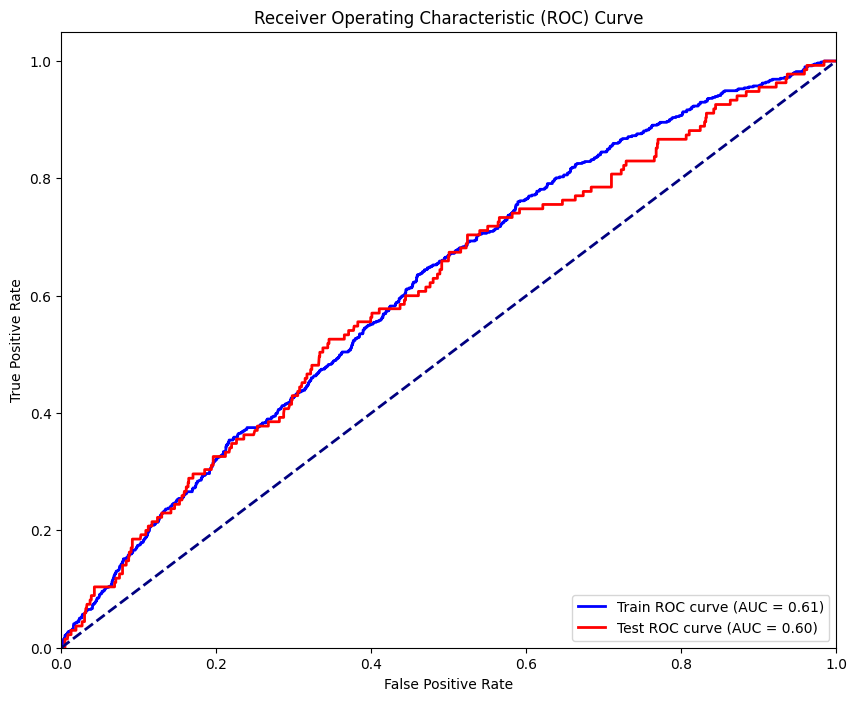


Classification Report (Train) - Optimized Threshold:
              precision    recall  f1-score   support

   Incorrect       0.92      0.56      0.70      4987
     Correct       0.14      0.60      0.23       613

    accuracy                           0.57      5600
   macro avg       0.53      0.58      0.46      5600
weighted avg       0.83      0.57      0.65      5600


Classification Report (Test) - Optimized Threshold:
              precision    recall  f1-score   support

   Incorrect       0.93      0.56      0.70      1265
     Correct       0.12      0.59      0.21       135

    accuracy                           0.56      1400
   macro avg       0.53      0.57      0.45      1400
weighted avg       0.85      0.56      0.65      1400



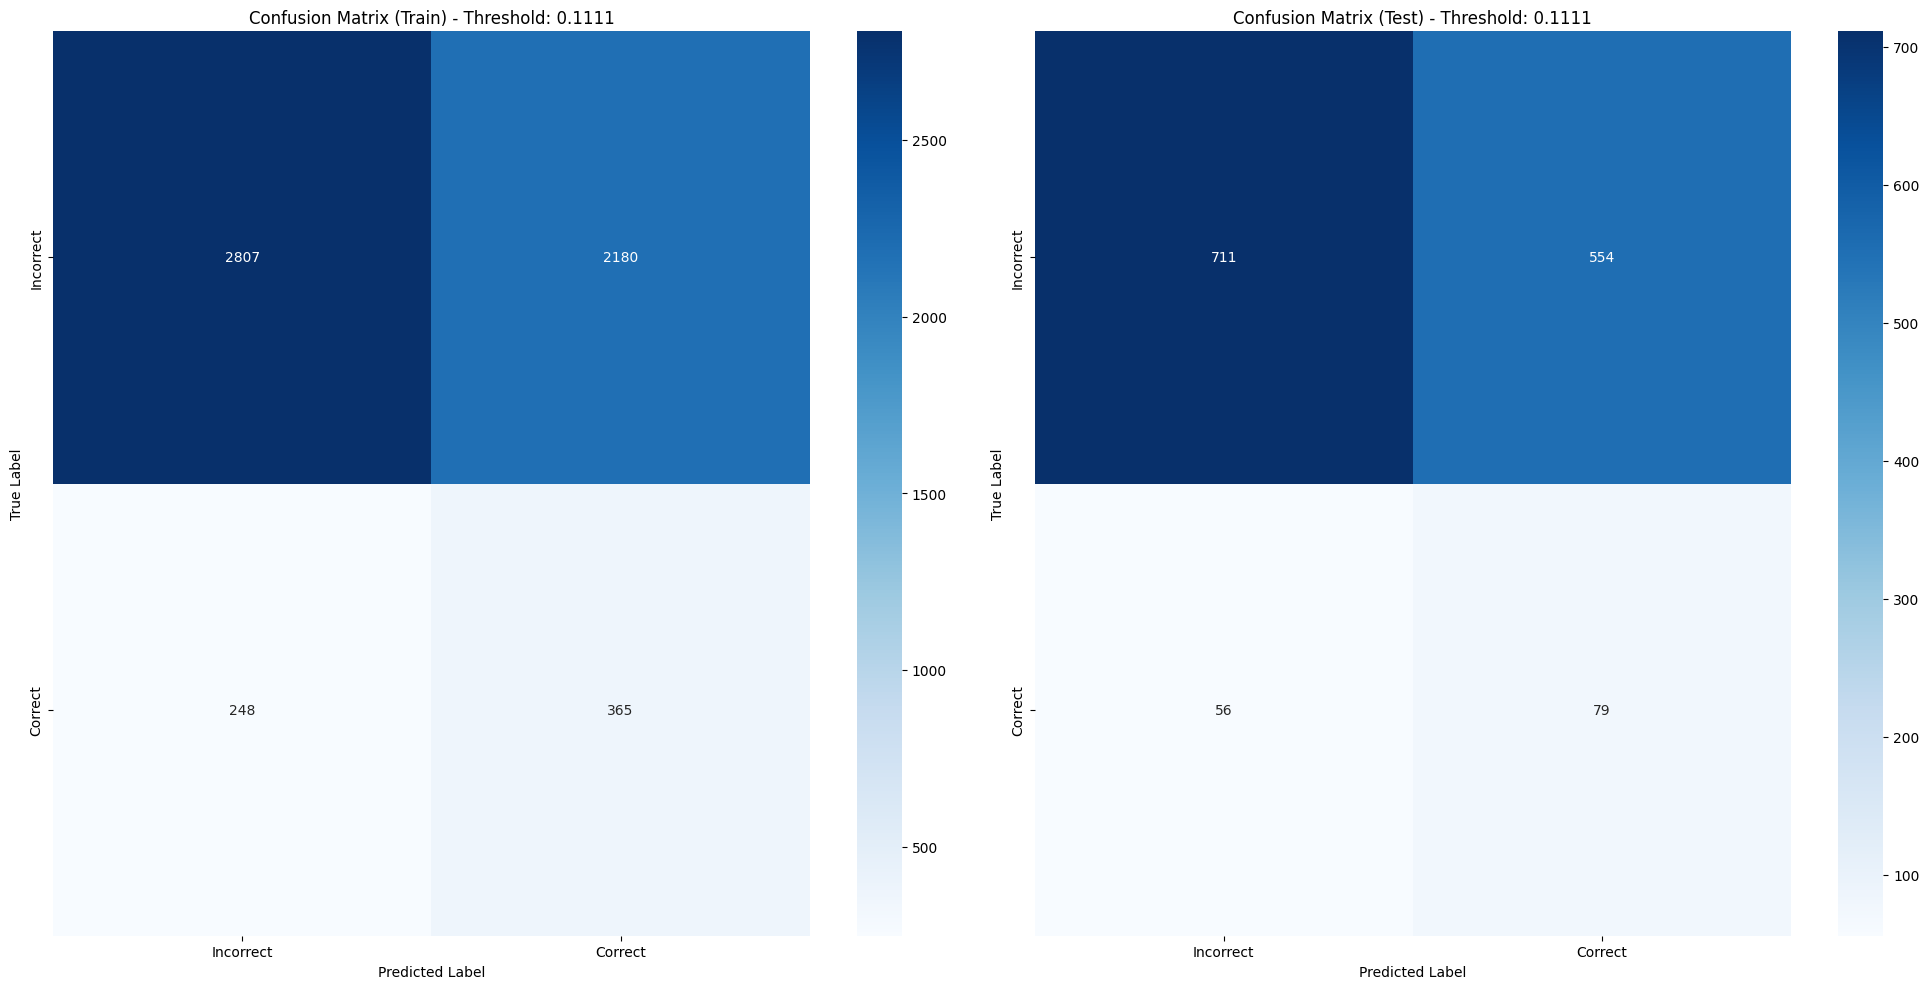

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, make_scorer, classification_report, confusion_matrix, f1_score
from sklearn.decomposition import PCA

# Prepare data for classification
X = np.stack(combined_df['embedding'].values)
y_correct = combined_df['is_correct'].values
X_train, X_test, y_train_correct, y_test_correct = train_test_split(X, y_correct, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Shape of training data:", X_train.shape)
print("Shape of test data:", X_test.shape)
print("Proportion of correct answers in training set:", y_train_correct.mean())
print("Proportion of correct answers in test set:", y_test_correct.mean())

# PCA for dimensionality reduction
pca = PCA(n_components=500)
X_train_selected = pca.fit_transform(X_train_scaled)
X_test_selected = pca.transform(X_test_scaled)

# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [0.01, 1, 100],
    'penalty': ['l1', 'l2'],
}

# Create a logistic regression model
model = LogisticRegression(max_iter=1000, random_state=42, solver='saga')

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    model, param_grid, cv=3, scoring='roc_auc', n_jobs=-1,
    return_train_score=True, error_score='raise'
)

grid_search.fit(X_train_selected, y_train_correct)

# Get the best model
best_model = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

# Get the number of non-zero coefficients (selected features)
n_selected_features = np.sum(best_model.coef_ != 0)
print(f"Number of features selected: {n_selected_features}")

# Make predictions on train and test sets
y_train_pred_proba = best_model.predict_proba(X_train_selected)[:, 1]
y_test_pred_proba = best_model.predict_proba(X_test_selected)[:, 1]

# Diagnostic prints
print("\ny_train_pred_proba distribution:")
print(np.histogram(y_train_pred_proba, bins=10))
print("\ny_test_pred_proba distribution:")
print(np.histogram(y_test_pred_proba, bins=10))

print("\ny_train_correct distribution:", np.bincount(y_train_correct))
print("y_test_correct distribution:", np.bincount(y_test_correct))

# Function to find the best threshold
def find_best_threshold(y_true, y_pred_proba):
    thresholds = np.linspace(0, 1, 100)
    f1_scores = [f1_score(y_true, (y_pred_proba >= threshold).astype(int)) for threshold in thresholds]
    best_threshold = thresholds[np.argmax(f1_scores)]
    return best_threshold

# Find best threshold using only training data
best_threshold = find_best_threshold(y_train_correct, y_train_pred_proba)

print(f"\nBest threshold for correctness (determined from training data): {best_threshold:.4f}")

# Create predictions using the best threshold for both train and test
y_train_pred_optimized = (y_train_pred_proba >= best_threshold).astype(int)
y_test_pred_optimized = (y_test_pred_proba >= best_threshold).astype(int)

# Calculate ROC curve and AUC for train and test sets
fpr_train, tpr_train, _ = roc_curve(y_train_correct, y_train_pred_proba)
roc_auc_train = roc_auc_score(y_train_correct, y_train_pred_proba)
fpr_test, tpr_test, _ = roc_curve(y_test_correct, y_test_pred_proba)
roc_auc_test = roc_auc_score(y_test_correct, y_test_pred_proba)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print classification reports with optimized threshold
print("\nClassification Report (Train) - Optimized Threshold:")
print(classification_report(y_train_correct, y_train_pred_optimized, target_names=['Incorrect', 'Correct']))
print("\nClassification Report (Test) - Optimized Threshold:")
print(classification_report(y_test_correct, y_test_pred_optimized, target_names=['Incorrect', 'Correct']))

# Plot confusion matrices with optimized threshold
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

sns.heatmap(confusion_matrix(y_train_correct, y_train_pred_optimized), annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title(f'Confusion Matrix (Train) - Threshold: {best_threshold:.4f}')
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')
ax1.set_xticklabels(['Incorrect', 'Correct'])
ax1.set_yticklabels(['Incorrect', 'Correct'])

sns.heatmap(confusion_matrix(y_test_correct, y_test_pred_optimized), annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_title(f'Confusion Matrix (Test) - Threshold: {best_threshold:.4f}')
ax2.set_ylabel('True Label')
ax2.set_xlabel('Predicted Label')
ax2.set_xticklabels(['Incorrect', 'Correct'])
ax2.set_yticklabels(['Incorrect', 'Correct'])

plt.tight_layout()
plt.show()

## Class-weighted Logistic Regression with Is_Correct as the Label

Shape of training data: (5600, 2048)
Shape of test data: (1400, 2048)
Proportion of correct answers in training set: 0.10946428571428571
Proportion of correct answers in test set: 0.09642857142857143
Class weights: {0: 0.5614597954682173, 1: 4.567699836867863}
Best parameters: {'C': 0.01, 'penalty': 'l1'}
Number of features selected: 104

y_train_pred_proba distribution:
(array([  43,  265,  516,  694,  848, 1067, 1114,  721,  275,   57]), array([0.14697758, 0.20868312, 0.27038867, 0.33209421, 0.39379975,
       0.4555053 , 0.51721084, 0.57891638, 0.64062193, 0.70232747,
       0.76403301]))

y_test_pred_proba distribution:
(array([ 26,  90, 147, 176, 202, 263, 259, 157,  60,  20]), array([0.17562352, 0.2334203 , 0.29121708, 0.34901386, 0.40681065,
       0.46460743, 0.52240421, 0.58020099, 0.63799777, 0.69579455,
       0.75359133]))

y_train_correct distribution: [4987  613]
y_test_correct distribution: [1265  135]

Best threshold for correctness (determined from training data): 0.53

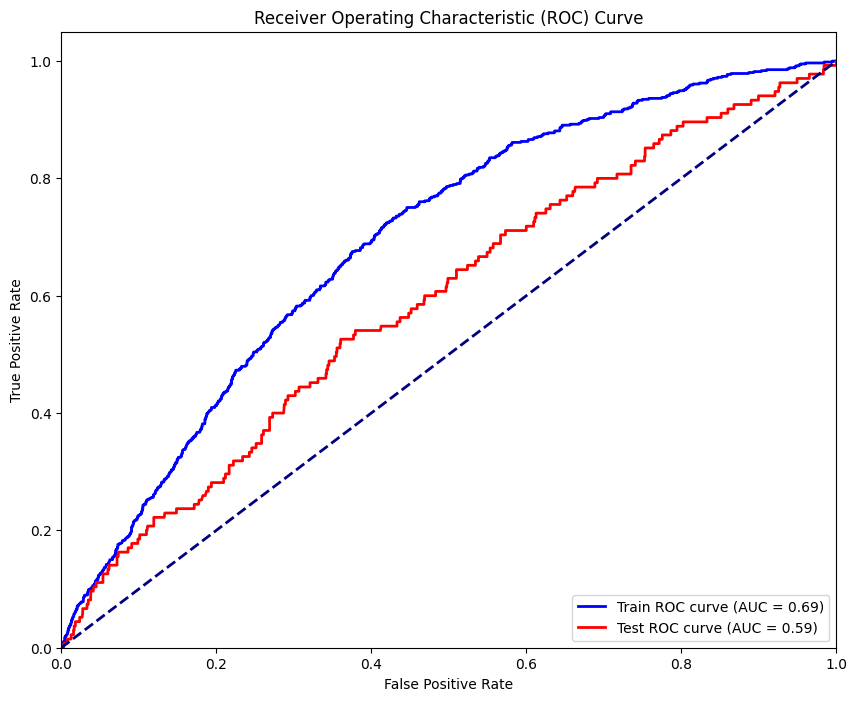


Classification Report (Train) - Optimized Threshold:
              precision    recall  f1-score   support

   Incorrect       0.93      0.72      0.81      4987
     Correct       0.19      0.55      0.29       613

    accuracy                           0.70      5600
   macro avg       0.56      0.63      0.55      5600
weighted avg       0.85      0.70      0.75      5600


Classification Report (Test) - Optimized Threshold:
              precision    recall  f1-score   support

   Incorrect       0.92      0.71      0.80      1265
     Correct       0.13      0.43      0.20       135

    accuracy                           0.68      1400
   macro avg       0.53      0.57      0.50      1400
weighted avg       0.84      0.68      0.74      1400



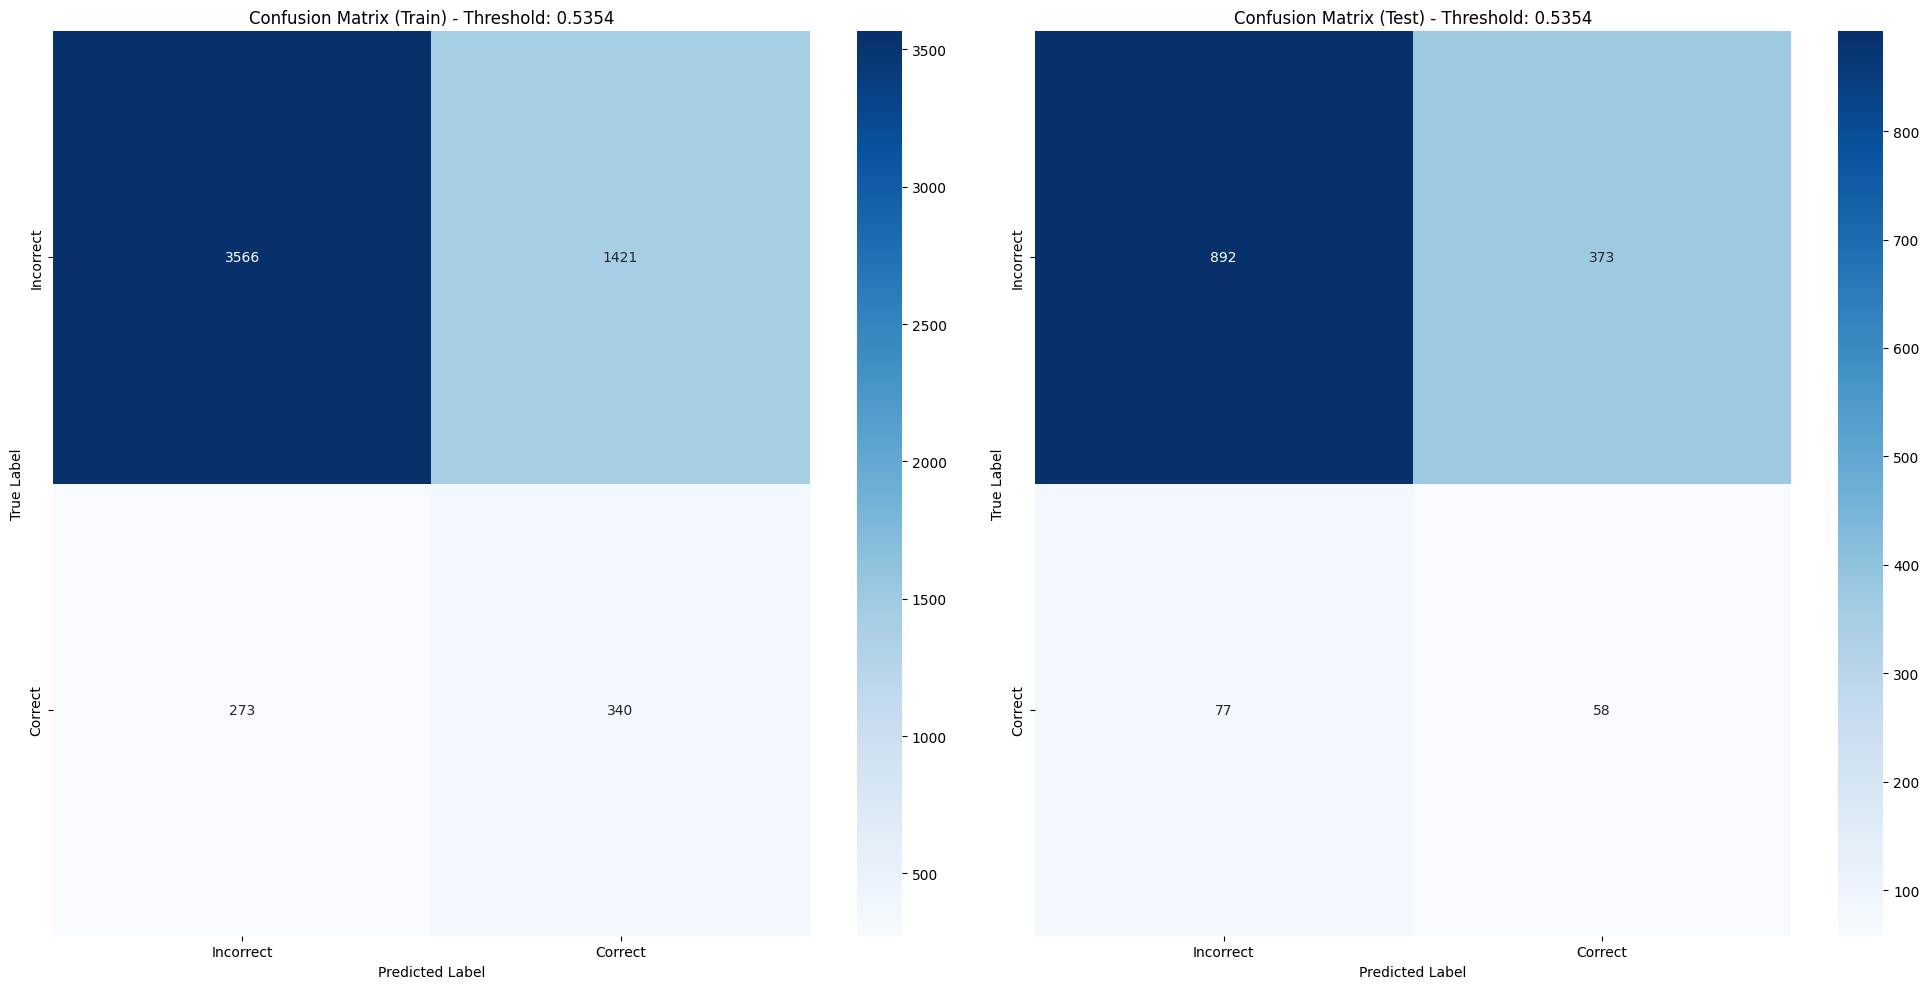

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, make_scorer, classification_report, confusion_matrix, f1_score
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight

# Prepare data for classification
X = np.stack(combined_df['embedding'].values)
y_correct = combined_df['is_correct'].values
X_train, X_test, y_train_correct, y_test_correct = train_test_split(X, y_correct, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Shape of training data:", X_train.shape)
print("Shape of test data:", X_test.shape)
print("Proportion of correct answers in training set:", y_train_correct.mean())
print("Proportion of correct answers in test set:", y_test_correct.mean())

# PCA for dimensionality reduction
pca = PCA(n_components=500)
X_train_selected = pca.fit_transform(X_train_scaled)
X_test_selected = pca.transform(X_test_scaled)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_correct), y=y_train_correct)
class_weight_dict = dict(zip(np.unique(y_train_correct), class_weights))

print("Class weights:", class_weight_dict)

# Create a logistic regression model with class weights
model = LogisticRegression(max_iter=1000, random_state=42, solver='saga', class_weight=class_weight_dict)

# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [0.01, 1, 100],
    'penalty': ['l1', 'l2'],
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    model, param_grid, cv=3, scoring='roc_auc', n_jobs=-1,
    return_train_score=True, error_score='raise'
)

grid_search.fit(X_train_selected, y_train_correct)

# Get the best model
best_model = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

# Get the number of non-zero coefficients (selected features)
n_selected_features = np.sum(best_model.coef_ != 0)
print(f"Number of features selected: {n_selected_features}")

# Make predictions on train and test sets
y_train_pred_proba = best_model.predict_proba(X_train_selected)[:, 1]
y_test_pred_proba = best_model.predict_proba(X_test_selected)[:, 1]

# Diagnostic prints
print("\ny_train_pred_proba distribution:")
print(np.histogram(y_train_pred_proba, bins=10))
print("\ny_test_pred_proba distribution:")
print(np.histogram(y_test_pred_proba, bins=10))

print("\ny_train_correct distribution:", np.bincount(y_train_correct))
print("y_test_correct distribution:", np.bincount(y_test_correct))

# Function to find the best threshold
def find_best_threshold(y_true, y_pred_proba):
    thresholds = np.linspace(0, 1, 100)
    f1_scores = [f1_score(y_true, (y_pred_proba >= threshold).astype(int)) for threshold in thresholds]
    best_threshold = thresholds[np.argmax(f1_scores)]
    return best_threshold

# Find best threshold using only training data
best_threshold = find_best_threshold(y_train_correct, y_train_pred_proba)

print(f"\nBest threshold for correctness (determined from training data): {best_threshold:.4f}")

# Create predictions using the best threshold for both train and test
y_train_pred_optimized = (y_train_pred_proba >= best_threshold).astype(int)
y_test_pred_optimized = (y_test_pred_proba >= best_threshold).astype(int)

# Calculate ROC curve and AUC for train and test sets
fpr_train, tpr_train, _ = roc_curve(y_train_correct, y_train_pred_proba)
roc_auc_train = roc_auc_score(y_train_correct, y_train_pred_proba)
fpr_test, tpr_test, _ = roc_curve(y_test_correct, y_test_pred_proba)
roc_auc_test = roc_auc_score(y_test_correct, y_test_pred_proba)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print classification reports with optimized threshold
print("\nClassification Report (Train) - Optimized Threshold:")
print(classification_report(y_train_correct, y_train_pred_optimized, target_names=['Incorrect', 'Correct']))
print("\nClassification Report (Test) - Optimized Threshold:")
print(classification_report(y_test_correct, y_test_pred_optimized, target_names=['Incorrect', 'Correct']))

# Plot confusion matrices with optimized threshold
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

sns.heatmap(confusion_matrix(y_train_correct, y_train_pred_optimized), annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title(f'Confusion Matrix (Train) - Threshold: {best_threshold:.4f}')
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')
ax1.set_xticklabels(['Incorrect', 'Correct'])
ax1.set_yticklabels(['Incorrect', 'Correct'])

sns.heatmap(confusion_matrix(y_test_correct, y_test_pred_optimized), annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_title(f'Confusion Matrix (Test) - Threshold: {best_threshold:.4f}')
ax2.set_ylabel('True Label')
ax2.set_xlabel('Predicted Label')
ax2.set_xticklabels(['Incorrect', 'Correct'])
ax2.set_yticklabels(['Incorrect', 'Correct'])

plt.tight_layout()
plt.show()

## Now, let's train using entropy score as the label. and then use it as a proxy for the hallucination

Shape of training data: (5600, 2048)
Shape of test data: (1400, 2048)
Proportion of low entropy in training set: 0.3575
Proportion of low entropy in test set: 0.33214285714285713
Proportion of correct answers in training set: 0.10946428571428571
Proportion of correct answers in test set: 0.09642857142857143
Best parameters: {'C': 0.01, 'penalty': 'l1'}
Number of features selected: 54

y_train_pred_proba distribution:
(array([  68,  384,  665, 1198, 1286,  768,  490,  500,  184,   57]), array([0.15325659, 0.19813273, 0.24300886, 0.287885  , 0.33276114,
       0.37763727, 0.42251341, 0.46738955, 0.51226568, 0.55714182,
       0.60201796]))

y_test_pred_proba distribution:
(array([ 55, 130, 186, 326, 264, 143, 135, 105,  46,  10]), array([0.17666617, 0.21918522, 0.26170426, 0.30422331, 0.34674235,
       0.38926139, 0.43178044, 0.47429948, 0.51681853, 0.55933757,
       0.60185662]))

y_train_entropy distribution: [3598 2002]
y_test_entropy distribution: [935 465]
y_train_correct distribu

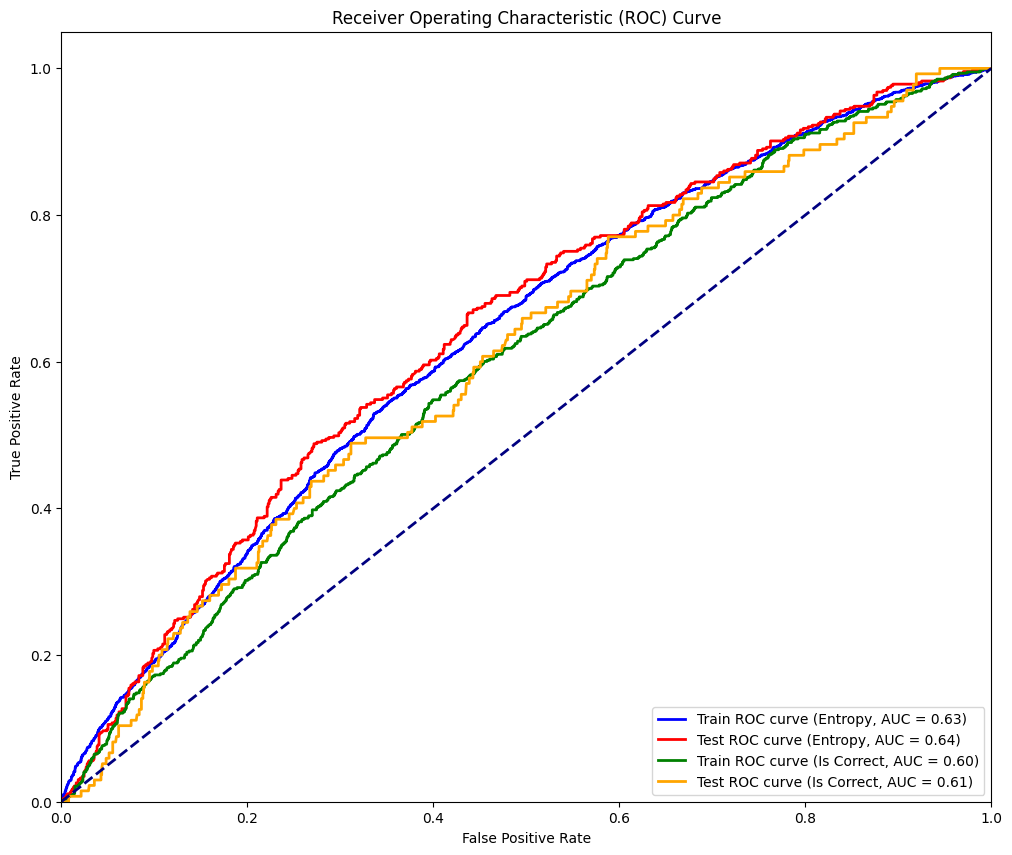


Classification Report (Train) - Optimized Threshold (Entropy):
              precision    recall  f1-score   support

High Entropy       0.77      0.36      0.49      3598
 Low Entropy       0.41      0.81      0.55      2002

    accuracy                           0.52      5600
   macro avg       0.59      0.58      0.52      5600
weighted avg       0.64      0.52      0.51      5600


Classification Report (Test) - Optimized Threshold (Entropy):
              precision    recall  f1-score   support

High Entropy       0.79      0.35      0.49       935
 Low Entropy       0.39      0.82      0.52       465

    accuracy                           0.51      1400
   macro avg       0.59      0.58      0.51      1400
weighted avg       0.66      0.51      0.50      1400


Classification Report (Train) - Optimized Threshold (Is Correct):
              precision    recall  f1-score   support

   Incorrect       0.91      0.61      0.73      4987
     Correct       0.14      0.54      0.23

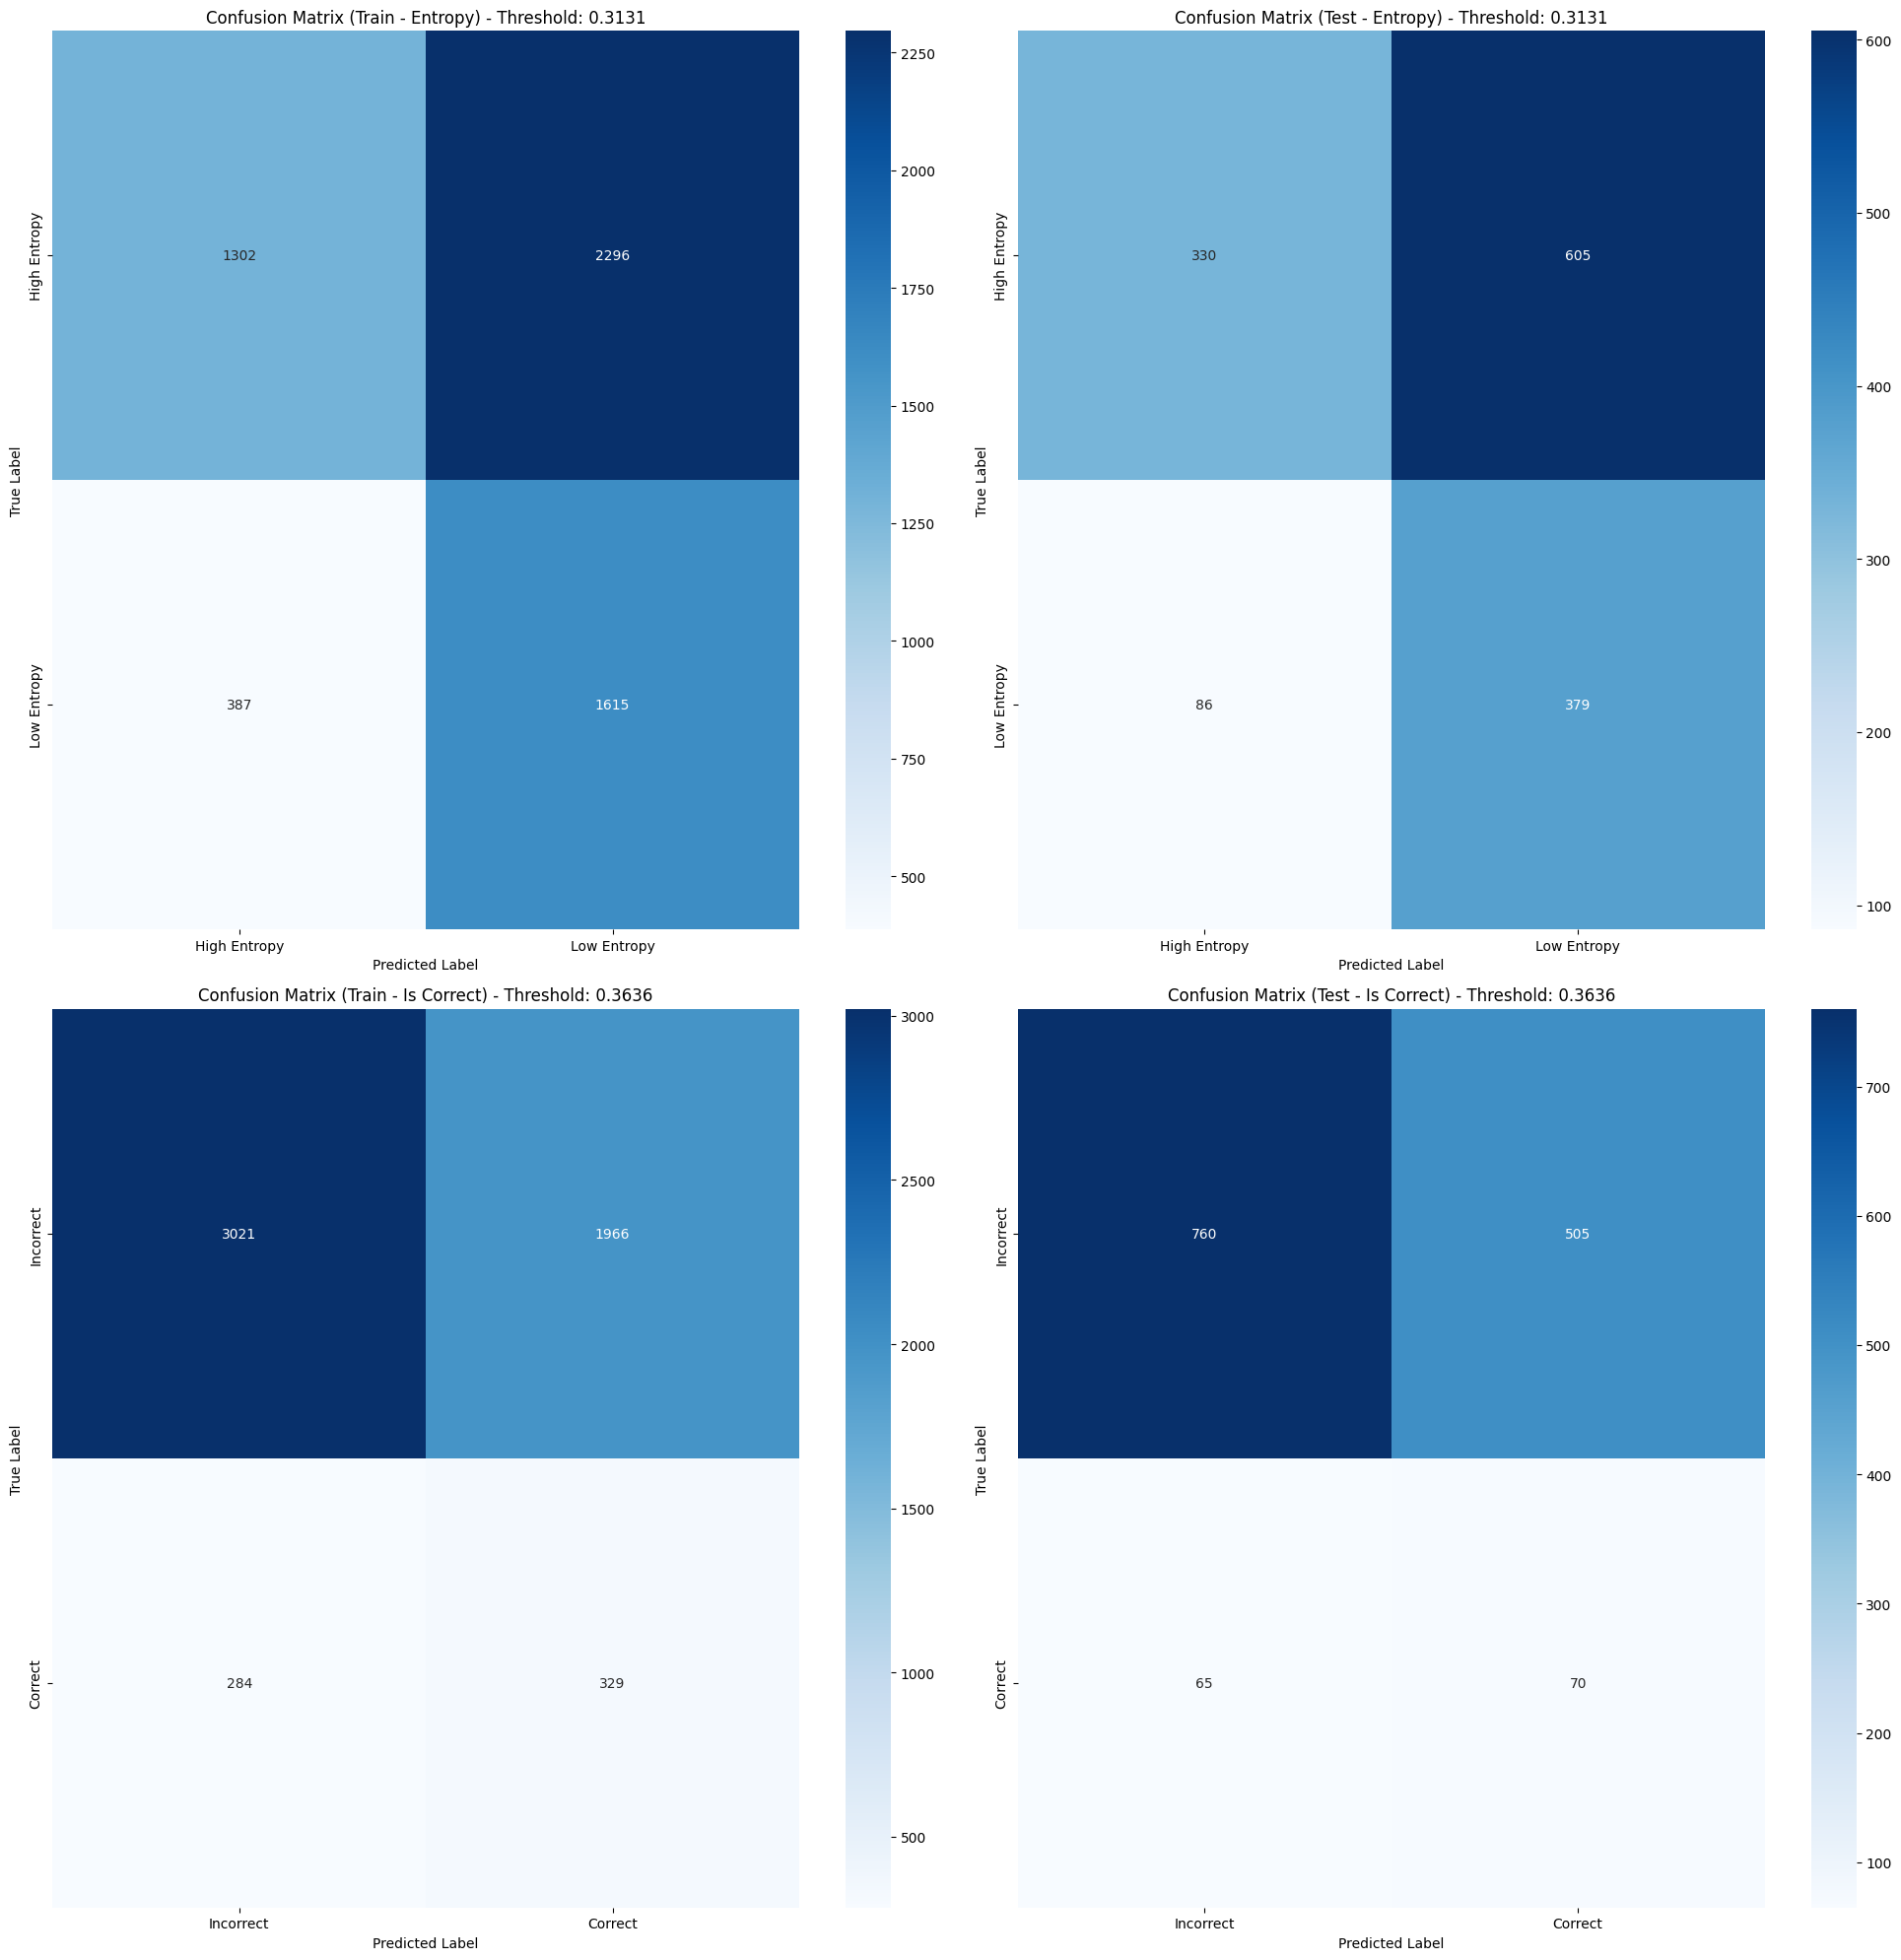

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, make_scorer, classification_report, confusion_matrix, f1_score
from sklearn.decomposition import PCA

# Create new column based on entropy (inverted)
combined_df['entropy_label'] = (combined_df['entropy'] < 1.69).astype(int)

# Prepare data for classification
X = np.stack(combined_df['embedding'].values)
y_entropy = combined_df['entropy_label'].values
y_correct = combined_df['is_correct'].values
X_train, X_test, y_train_entropy, y_test_entropy, y_train_correct, y_test_correct = train_test_split(X, y_entropy, y_correct, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Shape of training data:", X_train.shape)
print("Shape of test data:", X_test.shape)
print("Proportion of low entropy in training set:", y_train_entropy.mean())
print("Proportion of low entropy in test set:", y_test_entropy.mean())
print("Proportion of correct answers in training set:", y_train_correct.mean())
print("Proportion of correct answers in test set:", y_test_correct.mean())

# PCA for dimensionality reduction
pca = PCA(n_components=500)
X_train_selected = pca.fit_transform(X_train_scaled)
X_test_selected = pca.transform(X_test_scaled)

# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [0.01, 1, 100],
    'penalty': ['l1', 'l2'],
}

# Create a logistic regression model
model = LogisticRegression(max_iter=1000, random_state=42, solver='saga')

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    model, param_grid, cv=3, scoring='roc_auc', n_jobs=-1,
    return_train_score=True, error_score='raise'
)

grid_search.fit(X_train_selected, y_train_entropy)

# Get the best model
best_model = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

# Get the number of non-zero coefficients (selected features)
n_selected_features = np.sum(best_model.coef_ != 0)
print(f"Number of features selected: {n_selected_features}")

# Make predictions on train and test sets
y_train_pred_proba = best_model.predict_proba(X_train_selected)[:, 1]
y_test_pred_proba = best_model.predict_proba(X_test_selected)[:, 1]

# Diagnostic prints
print("\ny_train_pred_proba distribution:")
print(np.histogram(y_train_pred_proba, bins=10))
print("\ny_test_pred_proba distribution:")
print(np.histogram(y_test_pred_proba, bins=10))

print("\ny_train_entropy distribution:", np.bincount(y_train_entropy))
print("y_test_entropy distribution:", np.bincount(y_test_entropy))
print("y_train_correct distribution:", np.bincount(y_train_correct))
print("y_test_correct distribution:", np.bincount(y_test_correct))

# Function to find the best threshold
def find_best_threshold(y_true, y_pred_proba):
    thresholds = np.linspace(0, 1, 100)
    f1_scores = [f1_score(y_true, (y_pred_proba >= threshold).astype(int)) for threshold in thresholds]
    best_threshold = thresholds[np.argmax(f1_scores)]
    return best_threshold

# Find best thresholds using only training data
best_threshold_entropy = find_best_threshold(y_train_entropy, y_train_pred_proba)
best_threshold_correct = find_best_threshold(y_train_correct, y_train_pred_proba)

print(f"\nBest threshold for entropy (determined from training data): {best_threshold_entropy:.4f}")
print(f"Best threshold for correctness (determined from training data): {best_threshold_correct:.4f}")

# Create predictions using the best thresholds for both train and test
y_train_pred_optimized_entropy = (y_train_pred_proba >= best_threshold_entropy).astype(int)
y_test_pred_optimized_entropy = (y_test_pred_proba >= best_threshold_entropy).astype(int)
y_train_pred_optimized_correct = (y_train_pred_proba >= best_threshold_correct).astype(int)
y_test_pred_optimized_correct = (y_test_pred_proba >= best_threshold_correct).astype(int)

# Calculate ROC curve and AUC for train and test sets (entropy labels)
fpr_train_entropy, tpr_train_entropy, _ = roc_curve(y_train_entropy, y_train_pred_proba)
roc_auc_train_entropy = roc_auc_score(y_train_entropy, y_train_pred_proba)
fpr_test_entropy, tpr_test_entropy, _ = roc_curve(y_test_entropy, y_test_pred_proba)
roc_auc_test_entropy = roc_auc_score(y_test_entropy, y_test_pred_proba)

# Calculate ROC curve and AUC for train and test sets (is_correct labels)
fpr_train_correct, tpr_train_correct, _ = roc_curve(y_train_correct, y_train_pred_proba)
roc_auc_train_correct = roc_auc_score(y_train_correct, y_train_pred_proba)
fpr_test_correct, tpr_test_correct, _ = roc_curve(y_test_correct, y_test_pred_proba)
roc_auc_test_correct = roc_auc_score(y_test_correct, y_test_pred_proba)

# Plot ROC curves
plt.figure(figsize=(12, 10))
plt.plot(fpr_train_entropy, tpr_train_entropy, color='blue', lw=2, label=f'Train ROC curve (Entropy, AUC = {roc_auc_train_entropy:.2f})')
plt.plot(fpr_test_entropy, tpr_test_entropy, color='red', lw=2, label=f'Test ROC curve (Entropy, AUC = {roc_auc_test_entropy:.2f})')
plt.plot(fpr_train_correct, tpr_train_correct, color='green', lw=2, label=f'Train ROC curve (Is Correct, AUC = {roc_auc_train_correct:.2f})')
plt.plot(fpr_test_correct, tpr_test_correct, color='orange', lw=2, label=f'Test ROC curve (Is Correct, AUC = {roc_auc_test_correct:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print classification reports with optimized thresholds
print("\nClassification Report (Train) - Optimized Threshold (Entropy):")
print(classification_report(y_train_entropy, y_train_pred_optimized_entropy, target_names=['High Entropy', 'Low Entropy']))
print("\nClassification Report (Test) - Optimized Threshold (Entropy):")
print(classification_report(y_test_entropy, y_test_pred_optimized_entropy, target_names=['High Entropy', 'Low Entropy']))

print("\nClassification Report (Train) - Optimized Threshold (Is Correct):")
print(classification_report(y_train_correct, y_train_pred_optimized_correct, target_names=['Incorrect', 'Correct']))
print("\nClassification Report (Test) - Optimized Threshold (Is Correct):")
print(classification_report(y_test_correct, y_test_pred_optimized_correct, target_names=['Incorrect', 'Correct']))

# Plot confusion matrices with optimized thresholds
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 20))

sns.heatmap(confusion_matrix(y_train_entropy, y_train_pred_optimized_entropy), annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title(f'Confusion Matrix (Train - Entropy) - Threshold: {best_threshold_entropy:.4f}')
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')
ax1.set_xticklabels(['High Entropy', 'Low Entropy'])
ax1.set_yticklabels(['High Entropy', 'Low Entropy'])

sns.heatmap(confusion_matrix(y_test_entropy, y_test_pred_optimized_entropy), annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_title(f'Confusion Matrix (Test - Entropy) - Threshold: {best_threshold_entropy:.4f}')
ax2.set_ylabel('True Label')
ax2.set_xlabel('Predicted Label')
ax2.set_xticklabels(['High Entropy', 'Low Entropy'])
ax2.set_yticklabels(['High Entropy', 'Low Entropy'])

sns.heatmap(confusion_matrix(y_train_correct, y_train_pred_optimized_correct), annot=True, fmt='d', cmap='Blues', ax=ax3)
ax3.set_title(f'Confusion Matrix (Train - Is Correct) - Threshold: {best_threshold_correct:.4f}')
ax3.set_ylabel('True Label')
ax3.set_xlabel('Predicted Label')
ax3.set_xticklabels(['Incorrect', 'Correct'])
ax3.set_yticklabels(['Incorrect', 'Correct'])

sns.heatmap(confusion_matrix(y_test_correct, y_test_pred_optimized_correct), annot=True, fmt='d', cmap='Blues', ax=ax4)
ax4.set_title(f'Confusion Matrix (Test - Is Correct) - Threshold: {best_threshold_correct:.4f}')
ax4.set_ylabel('True Label')
ax4.set_xlabel('Predicted Label')
ax4.set_xticklabels(['Incorrect', 'Correct'])
ax4.set_yticklabels(['Incorrect', 'Correct'])

plt.tight_layout()
plt.show()